# Predicting Esports Matches Using `TrueSkill` Library

## Introduction

### TrueSkill

TrueSkill is a ranking system designed by [Microsoft Research](https://www.microsoft.com/en-us/research):

> "The TrueSkill ranking system is a skill based ranking system for Xbox Live developed at Microsoft Research. The purpose of a ranking system is to both identify and track the skills of gamers in a game (mode) in order to be able to match them into competitive matches. The TrueSkill ranking system only uses the final standings of all teams in a game in order to update the skill estimates (ranks) of all gamers playing in this game. Ranking systems have been proposed for many sports but possibly the most prominent ranking system in use today is ELO."

It assume that the skill of a given player conforms Normal Distribution. By playing more and more games, the system knows you better, so the σ will be lower and lower.

![skill](skill.jpg)

For a team game, it assumes that the skill of a team is the sum of the skills of its players. In this way we can use it for **sports prediction**: by training the skills of the players based on the history games, we can predict the results of the upcoming games, which are always the dreams of sport fans!

In this tutorial, we will use the Python library `trueskill` to do the task on Overwatch League, a global esport league.

## Setups

### Python Version

Python 3.6 is used for this tutorial.

### Libraries

The following libraries are needed for this tutorial:

- **trueskill**
- request
- matplotlib
- numpy

In [3]:
from collections import defaultdict, deque
from functools import cmp_to_key
from itertools import chain
from math import sqrt
from pprint import pprint
from random import choices, random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from trueskill import calc_draw_margin, Rating, TrueSkill

from fetcher import load_games
from game import Roster, Game

### Loading the Data

Overwatch League is a global esports league with city-based teams based on the Blizzard video game **Overwatch**. There are **12 teams** in total, and there will be many matches per week.

![owl-matches](owl-matches.png)

Each of the matches is a **Best-of-4** match played on **4 maps**. If two teams draw after 4 games, a tie-breaker map will be played.

![match-summary](match-summary.png)

The results of all the games are stored in `game.csv`. There are two types of rows:

- **Future Match**: A match that has not been completed. It contains the following fields:
    - `match_id`: The id of the match.
    - `stage`: The stage of the match.
    - `start_time`: The start time of the match.
    - `team{1,2}`: The two teams involved in this match.
    - `match_format`: The format of this match. Possible values are `regular` and `title`.
- **Past Game**: A game that has completed. It contains all the above fields, as well as:
    - `game_id`: The id of the game.
    - `game_number`: The order of the game in the corresponding match. Start from 1.
    - `map_name`: The name of the map.
    - `score{1,2}`: The score of the game.
    - `team{1,2}_p{1,2,3,4,5,6}`: The players of each team in this game.

We can use the `load_games()` function to load all the rows into the `Game` objects. For a future match, some of the fields are set to `None`.

In [4]:
past_games, future_matches = load_games()
past_games[0]._asdict(), future_matches[0]._asdict()

(OrderedDict([('match_id', 10525),
              ('stage', 'Preseason'),
              ('start_time', datetime.datetime(2017, 12, 6, 16, 0)),
              ('teams', ('FLA', 'SFS')),
              ('match_format', 'regular'),
              ('game_id', 4759),
              ('game_number', 1),
              ('map_name', 'dorado'),
              ('score', (1, 2)),
              ('rosters',
               (('Zebbosai', 'TviQ', 'Zuppeh', 'Logix', 'Manneten', 'CWoosH'),
                ('dhaK', 'sleepy', 'Danteh', 'BABYBAY', 'Nomy', 'Nevix')))]),
 OrderedDict([('match_id', 10582),
              ('stage', 'Stage 2'),
              ('start_time', datetime.datetime(2018, 3, 23, 16, 0)),
              ('teams', ('SEO', 'FLA')),
              ('match_format', 'regular'),
              ('game_id', None),
              ('game_number', None),
              ('map_name', None),
              ('score', None),
              ('rosters', None)]))

## Parameters

Then we need to choose the parameters for the TrueSkill algorithm. This should be done by tuning the model on the history data. For the simplicity of the tutorial, we omit this process and use the following parameters:

- *mu* = 2500
- *sigma* = 2500 / 3
- *beta* = 2500 / 2
- *tau* = 25 / 3
- *draw_probability* = 0.06 or 0 (based on the map)

Note that we have two *draw_probability*. This is because there are many types of maps in Overwatch. Some of the maps are drawable, while others are not.

Using these parameters, we can create `TrueSkill` objects by:

    TrueSkill(mu=25.0, sigma=8.333333333333334, beta=4.166666666666667, tau=0.08333333333333334, draw_probability=0.1)
    
Here we created two `TrueSkill` objects, one for drawable games and the other for undrawable games.

In [5]:
MU = 2500.0
SIGMA = 2500.0 / 3.0
BETA = 2500.0 / 2.0
TAU = 25.0 / 3.0
P_DRAW = 0.06

env_drawable = TrueSkill(mu=MU, sigma=SIGMA, beta=BETA, tau=TAU, draw_probability=P_DRAW)
env_undrawable = TrueSkill(mu=MU, sigma=SIGMA, beta=BETA, tau=TAU, draw_probability=0.0)

## Implementation

### Rating Jar

Using the `TrueSkill` object, we can create a rating jar which stores the ratings of all the players. We use `defaultdict` here so that if a rating cannot be found, a default rating is returned.

In [6]:
TEAMS = ['BOS', 'DAL', 'FLA', 'GLA', 'HOU', 'LDN', 'NYE', 'PHI', 'SEO', 'SFS', 'SHD', 'VAL']
ratings = defaultdict(lambda: env_drawable.create_rating())

### Roster Queue

As we explained ealier, TrueSkill assigns a skill rating for every individual players. However, we cannot know the roster of the two teams before a match starts. Thus, in order to predict matches in advance, we have to "guess" the rosters of teams beforehand.

Here we will use a queue approach: the roster that has the highest rating in the past 12 games will be used. In other words, we predict that the team will use their "strongest" roster that they have used recently. If such a roster cannot be found, we will just return six empty strings, which will lead to six default ratings.

In [7]:
roster_queues = defaultdict(lambda: deque(maxlen=12))
best_rosters = defaultdict(lambda: [''] * 6)


def roster_rating_lower_bound(roster):
    sum_mu = sum(ratings[name].mu for name in roster)
    sum_sigma = sqrt(sum(ratings[name].sigma**2 for name in roster))

    mu = sum_mu / 6.0
    sigma = sum_sigma / 6.0
    
    return mu - 3.0 * sigma


def update_best_roster(team, roster):
    roster_queues[team].appendleft(roster)
    best_rosters[team] = max(roster_queues[team], key=roster_rating_lower_bound)

### Training

In order to predict future matches, we have to first train the model so that we can have the ratings for all the players. This is done by the function `TrueSkill.rate()`:

    TrueSkill.rate(rating_groups, ranks=None) -> new_rating_groups

where `rating_groups` is the ratings of the teams, and `ranks` is the ranks of the teams. For example, if team 1 wins and team 2 losses, the `ranks` should be `[0, 1]`, meaning that team 1 ranks `0` while team 2 ranks `1`.

In [8]:
def train(game):
    """Given a game result, train the underlying model.
    Return the prediction point for this game before training."""
    env = env_drawable if game.drawable else env_undrawable
    teams_ratings = [[ratings[name] for name in roster] for roster in game.rosters]
    
    if game.score[0] > game.score[1]:
        ranks = [0, 1]  # Team 1 wins.
    elif game.score[0] == game.score[1]:
        ranks = [0, 0]  # Draw.
    else:
        ranks = [1, 0]  # Team 2 wins.
    
    teams_ratings = env.rate(teams_ratings, ranks=ranks)
    
    for team, roster, team_ratings in zip(game.teams, game.rosters, teams_ratings):
        # Update ratings for the players.
        for name, rating in zip(roster, team_ratings):
            ratings[name] = rating

        update_best_roster(team, roster)  # Update the best roster for this team.


for game in past_games:
    train(game)
ratings['Logix']

trueskill.Rating(mu=2461.962, sigma=542.731)

We can draw the means of all the ratings in a histogram:

(array([ 1.,  5.,  5., 10., 20., 28., 21., 15.,  7.,  2.]),
 array([1004.11038434, 1274.4307963 , 1544.75120826, 1815.07162022,
        2085.39203218, 2355.71244414, 2626.03285609, 2896.35326805,
        3166.67368001, 3436.99409197, 3707.31450393]),
 <a list of 10 Patch objects>)

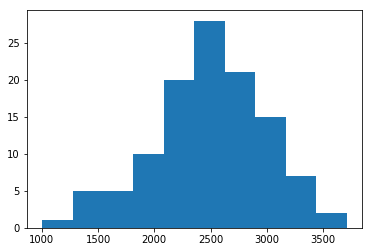

In [9]:
mus = [r.mu for r in ratings.values()]
plt.hist(mus)

As well as the best roster for a given team:

In [10]:
best_rosters['SHD']

('MG', 'Xushu', 'Freefeel', 'Fiveking', 'Ado', 'Fearless')

### Predicting Matches

Now that we have the ratings for all the players in the league, we can predict the future matches.

First we want to precit a single game. There are some math here so the code is a little bit hard to read, but the idea is to compute `P(X > Y)`, where `X` and `Y` are two random variables.

In [11]:
def predict(rosters, drawable=False):
    env = env_drawable if drawable else env_undrawable
    teams_ratings = [[ratings[name] for name in roster] for roster in rosters]
    
    delta_mu = (sum(r.mu for r in teams_ratings[0]) - sum(r.mu for r in teams_ratings[1]))
    draw_margin = calc_draw_margin(env.draw_probability, 12, env=env)
    sum_sigma = sum(r.sigma**2 for r in chain(*teams_ratings))
    denom = sqrt(12 * env.beta**2 + sum_sigma)

    p_win = env.cdf((delta_mu - draw_margin) / denom)
    p_not_loss = env.cdf((delta_mu + draw_margin) / denom)

    return p_win, p_not_loss - p_win

predict([('Zebbosai', 'TviQ', 'Zuppeh', 'Logix', 'Manneten', 'CWoosH'),
         ('dhaK', 'sleepy', 'Danteh', 'BABYBAY', 'Nomy', 'Nevix')], drawable=True)

(0.5042132316828962, 0.055065096636604305)

Using probabilities above, we can in turn predict all the possible results of a given match.

In [12]:
def predict_bo_match_score(rosters, drawables):
    """Predict the scores of a given Best-Of-N match."""
    p_scores = defaultdict(float)
    p_scores[(0, 0)] = 1.0

    p_undrawable = predict(rosters, drawable=False)
    p_drawable = predict(rosters, drawable=True)

    for drawable in drawables:
        p_win, p_draw = p_drawable if drawable else p_undrawable
        p_loss = 1.0 - p_win - p_draw
        new_p_scores = defaultdict(float)

        for (score1, score2), p in p_scores.items():
            new_p_scores[(score1 + 1, score2)] += p * p_win
            new_p_scores[(score1, score2 + 1)] += p * p_loss
            if drawable:
                new_p_scores[(score1, score2)] += p * p_draw

        p_scores = new_p_scores

    # Add a tie-breaker game if needed.
    p_win, p_draw = p_undrawable
    new_p_scores = defaultdict(float)

    for (score1, score2), p in p_scores.items():
        if score1 == score2:
            new_p_scores[(score1 + 1, score2)] += p * p_win
            new_p_scores[(score1, score2 + 1)] += p * p_loss
        else:
            new_p_scores[(score1, score2)] += p

    p_scores = new_p_scores
    
    return p_scores


def predict_match_score(rosters, match_format='regular'):
    """Predict the scores of a given match."""
    if match_format == 'regular':
        drawables = [True, False, True, False]
    else:
        drawables = [False, False, True, True, False]
    
    return predict_bo_match_score(rosters, drawables=drawables)


predict_match_score([('Zebbosai', 'TviQ', 'Zuppeh', 'Logix', 'Manneten', 'CWoosH'),
                     ('dhaK', 'sleepy', 'Danteh', 'BABYBAY', 'Nomy', 'Nevix')])

defaultdict(float,
            {(0, 2): 0.0006646222699297546,
             (0, 3): 0.01063880591266652,
             (0, 4): 0.042574630872416745,
             (1, 2): 0.03704846249422922,
             (1, 3): 0.19414050604488414,
             (2, 0): 0.0008576010406760136,
             (2, 1): 0.042182981550115003,
             (2, 3): 0.15542536376095822,
             (3, 0): 0.015705549199978065,
             (3, 1): 0.25230229093771395,
             (3, 2): 0.17655381140884602,
             (4, 0): 0.07190531027064047})

The above results are a little bit hard to understand. Sometime we just want two numbers: **how likely** will I win, and **how much** will I win?

This can be done by calculating the **win percentage** and the **map differential expectation**.

In [13]:
def predict_match(rosters, match_format='regular'):
    """Predict the win probability & diff expectation of a given match."""
    p_scores = predict_match_score(rosters, match_format)
    p_win = 0.0
    e_diff = 0.0

    for (score1, score2), p in p_scores.items():
        if score1 > score2:
            p_win += p
        e_diff += p * (score1 - score2)

    return p_win, e_diff


for match in future_matches[:6]:
    p_win, e_diff = predict_match([best_rosters[team] for team in match.teams])
    print(f'p_win = {round(p_win * 100):>3}%, e_diff = {e_diff:+.1f}')

p_win =  82%, e_diff = +1.6
p_win =  86%, e_diff = +1.8
p_win = 100%, e_diff = +3.8
p_win =   1%, e_diff = -3.2
p_win =   9%, e_diff = -2.2
p_win =  41%, e_diff = -0.4


Which can be visualized as following.

![Matches](matches.png)

### Predicting Stages

For each stage, the standing of the teams is determined by their match wins and map differentials.

![stage-standing](stage-standing.png)

At the end of that stage, the top 3 teams will enter the **stage title matches**, fighting for the stage champion.

![stage-finals](stage-finals.png)

As we can predict the match results now, we can use that infomation to predict the stage champions. However, the exact probabilities are very hard to compute. For example, there are 12 possible outcomes for any given match, so 60 matches will lead to 12^60 ≈ 5.6 \* 10^64 states.

An alternative way to do that is by simulation. We can simulate the future matches many times to approximate the probabilities. This will lower the time complexity from O(12^N) to O(N), while still giving reasonable results.

The win rate between any two teams can be calculated in advance.

In [14]:
def all_p_wins(match_format):
    p_wins = {}
    
    for team1 in TEAMS:
        for team2 in TEAMS:
            teams = (team1, team2)
            rosters = [best_rosters[team] for team in teams]
            p_wins[teams], _ = predict_match(rosters, match_format)
            
    return p_wins

all_p_wins('regular')[('DAL', 'FLA')]

0.4509863401911519

Also, in order to use the `random.choices` function, we have to convert the possibilities of all the scores to cum weights.

In [15]:
def predict_matches_scores_cum_weights(matches):
    scores_list = []
    cum_weights_list = []

    for match in matches:
        p_scores = predict_match_score([best_rosters[team] for team in match.teams])
        scores = []
        cum_weights = []
        cum_weight = 0.0

        for score, p in p_scores.items():
            scores.append(score)
            cum_weight += p
            cum_weights.append(cum_weight)

        scores_list.append(scores)
        cum_weights_list.append(cum_weights)

    return scores_list, cum_weights_list

scores_list, cum_weights_list = predict_matches_scores_cum_weights(future_matches)
print(scores_list[0])
print([round(cum_p, 4) for cum_p in cum_weights_list[0]])

[(4, 0), (3, 1), (3, 2), (2, 3), (3, 0), (2, 1), (1, 3), (1, 2), (0, 4), (0, 3), (2, 0), (0, 2)]
[0.2094, 0.5796, 0.7487, 0.825, 0.8556, 0.8972, 0.9695, 0.988, 0.996, 0.9987, 0.9998, 1.0]


We also have to sort the teams by their wins, map differentials, etc., and apply tie breakers if needed. This can be done by creating a comparision function, and then use `sorted` to sort the teams.

In [16]:
def top3_teams(wins, map_diffs, head_to_head_map_diffs, p_wins_regular):
    def cmp_team(team1, team2):
        if wins[team1] < wins[team2]:
            return -1
        elif wins[team1] > wins[team2]:
            return 1
        elif map_diffs[team1] < map_diffs[team2]:
            return -1
        elif map_diffs[team1] > map_diffs[team2]:
            return 1
        elif head_to_head_map_diffs[(team1, team2)] < 0:
            return -1
        elif head_to_head_map_diffs[(team1, team2)] > 0:
            return 1
        elif random() < p_wins_regular[(team1, team2)]:
            return 1
        else:
            return -1

    teams = list(sorted(TEAMS, key=cmp_to_key(cmp_team), reverse=True))
    return teams[:3]

Now we have all the tools we need. We can move on and filter the remaining matches of the current stage out of all the future matches.

In [18]:
stage = past_games[-1].stage
stage_past_games = [game for game in past_games if game.stage == stage]
stage_future_matches = [match for match in future_matches if match.stage == stage]

And calculate the current standings. We will need three numbers for the comparision function:

- `stage_wins`
- `stage_map_diffs`
- `stage_head_to_head_map_diffs`

In [19]:
# Group past games by matches.
stage_past_matches = defaultdict(list)
for game in stage_past_games:
    if game.stage == stage:
        stage_past_matches[game.match_id].append(game)

stage_wins = defaultdict(int)
stage_map_diffs = defaultdict(int)
stage_head_to_head_map_diffs = defaultdict(int)

for games in stage_past_matches.values():
    score = [0, 0]

    for game in games:
        if game.score[0] > game.score[1]:  # Team 1 wins the game.
            winner = game.teams[0]
            loser = game.teams[1]
            score[0] += 1
        elif game.score[0] < game.score[1]:  # Team 2 wins the game.
            winner = game.teams[1]
            loser = game.teams[0]
            score[1] += 1
        else:  # Draw.
            continue

        stage_map_diffs[winner] += 1
        stage_map_diffs[loser] -= 1
        stage_head_to_head_map_diffs[(winner, loser)] += 1
        stage_head_to_head_map_diffs[(loser, winner)] -= 1

    if score[0] > score[1]:  # Team 1 wins the match.
        stage_wins[game.teams[0]] += 1
    else:  # Team 2 wins the match.
        stage_wins[game.teams[1]] += 1

Fianlly, it's time to do the simulations!

In [20]:
scores_list, cum_weights_list = predict_matches_scores_cum_weights(future_matches)
p_wins_regular = all_p_wins('regular')
p_wins_title = all_p_wins('title')

top3_count = defaultdict(int)
top1_count = defaultdict(int)

ITERS = 100000

for _ in range(ITERS):
    wins = stage_wins.copy()
    map_diffs = stage_map_diffs.copy()
    head_to_head_map_diffs = stage_head_to_head_map_diffs.copy()

    for match, scores, cum_weights in zip(stage_future_matches, scores_list, cum_weights_list):
        team1, team2 = match.teams
        score1, score2 = choices(scores, cum_weights=cum_weights)[0]

        if score1 > score2:
            wins[team1] += 1
        elif score1 < score2:
            wins[team2] += 1

        map_diff = score1 - score2
        map_diffs[team1] += map_diff
        map_diffs[team2] -= map_diff

        head_to_head_map_diffs[(team1, team2)] += map_diff
        head_to_head_map_diffs[(team2, team1)] -= map_diff

    # Determine top 3 teams.
    top3 = top3_teams(wins, map_diffs, head_to_head_map_diffs, p_wins_regular)
    for team in top3:
        top3_count[team] += 1

    # Determine top 1 teams.
    first, second, third = top3

    if random() < p_wins_title[(third, second)]:
        second = third
    if random() < p_wins_title[(second, first)]:
        first = second

    top1_count[first] += 1

prediction = {team: (top3_count[team] / ITERS, top1_count[team] / ITERS) for team in TEAMS}
prediction

{'BOS': (0.0, 0.0),
 'DAL': (0.0, 0.0),
 'FLA': (0.0, 0.0),
 'GLA': (0.12862, 0.00161),
 'HOU': (0.0, 0.0),
 'LDN': (0.99997, 0.64703),
 'NYE': (1.0, 0.29392),
 'PHI': (0.81665, 0.05644),
 'SEO': (0.05476, 0.001),
 'SFS': (0.0, 0.0),
 'SHD': (0.0, 0.0),
 'VAL': (0.0, 0.0)}

Note that we have some `0.0` and some `1.0` in the above results. However, it does not mean that the team cannot be Top 3, or have already secured a spot in top 3. To handle those cases, we have to calculate whether a team has won enough games to become a top 3.

In [21]:
# Normalize 0% and 100% for predictions.
wins = {team: (stage_wins[team], stage_map_diffs[team]) for team in TEAMS}
min_wins = wins.copy()
max_wins = wins.copy()

for match in stage_future_matches:
    for team in match.teams:
        win, map_diff = min_wins[team]
        min_wins[team] = (win, map_diff - 4)

        win, map_diff = max_wins[team]
        max_wins[team] = (win + 1, map_diff + 4)

min_3rd_wins = list(sorted(min_wins.values()))[-3]
max_4th_wins = list(sorted(max_wins.values()))[-4]

for team, (p_top3, p_top1) in prediction.items():
    if max_wins[team] < min_3rd_wins:
        p_top3 = False
        p_top1 = False
    elif min_wins[team] > max_4th_wins:
        p_top3 = True

    prediction[team] = (p_top3, p_top1)
    
prediction

{'BOS': (False, False),
 'DAL': (False, False),
 'FLA': (False, False),
 'GLA': (0.12862, 0.00161),
 'HOU': (False, False),
 'LDN': (0.99997, 0.64703),
 'NYE': (True, 0.29392),
 'PHI': (0.81665, 0.05644),
 'SEO': (0.05476, 0.001),
 'SFS': (False, False),
 'SHD': (False, False),
 'VAL': (0.0, 0.0)}

Great! As you can see, the `False` means "impossible", while the `True` means "absolutely". Now we can visualize our data!

![Standings](standings.png)

I have actually create a [website](https://owl.clumsy.li) to show these data, which even includes the rating trends of all the teams.

![rating-trend](rating-trend.png)

##  Further Readings

- [My Website for Data Visualization of This Tutorial](owl.clumsy.li)
- [TrueSkill — trueskill 0.4.4 documentation](http://trueskill.org)
- [https://www.microsoft.com/en-us/research/project/trueskill-ranking-system](https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/)
- [TrueSkill(TM): A Bayesian Skill Rating System](https://www.microsoft.com/en-us/research/publication/trueskilltm-a-bayesian-skill-rating-system/?from=http%3A%2F%2Fresearch.microsoft.com%2Fapps%2Fpubs%2Fdefault.aspx%3Fid%3D67956)
- [The Math Behind TrueSkill](http://www.moserware.com/assets/computing-your-skill/The%20Math%20Behind%20TrueSkill.pdf)